In [45]:
import pandas as pd
import re
import ast
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from collections import Counter
from pathlib import Path

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
nlp = spacy.load("en_core_web_sm", disable=["parser"])

In [47]:
NUM_RE = re.compile(r'[\d¼½¾⅓⅔⅛]+|[0-9]+(?:[.-][0-9]+)?')
PUNCT_RE = re.compile(r'[^a-zA-Z\s]')

In [48]:
def safe_eval_list(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x)
    except Exception:
        if isinstance(x, str):
            if '|' in x:
                parts = [p.strip() for p in x.split('|') if p.strip()]
            else:
                parts = [p.strip() for p in x.split(',') if p.strip()]
            return parts
    return []

In [49]:
df = pd.read_csv("Food Ingredients and Recipe Dataset with Image Name Mapping.csv")

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13501 entries, 0 to 13500
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           13501 non-null  int64 
 1   Title                13496 non-null  object
 2   Ingredients          13501 non-null  object
 3   Instructions         13493 non-null  object
 4   Image_Name           13501 non-null  object
 5   Cleaned_Ingredients  13501 non-null  object
dtypes: int64(1), object(5)
memory usage: 633.0+ KB


In [51]:
df.isnull().sum()

Unnamed: 0             0
Title                  5
Ingredients            0
Instructions           8
Image_Name             0
Cleaned_Ingredients    0
dtype: int64

In [52]:
df = df.dropna()
df.isnull().sum()

Unnamed: 0             0
Title                  0
Ingredients            0
Instructions           0
Image_Name             0
Cleaned_Ingredients    0
dtype: int64

In [53]:
df.head()

,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups)', '2 medium apples (such as Gala or Pink Lady; about 14 oz. total), cored, cut into 1"" pieces', '2 Tbsp. extra-virgin olive oil', '½ small red onion, thinly sliced', '3 Tbsp. apple cider vinegar', '1 Tbsp. white miso', '¼ cup all-purpose flour', '2 Tbsp. unsalted butter, room temperature', '¼ cup dry white wine', '2 cups unsalted chicken broth', '2 tsp. white miso', 'Kosher salt, freshly ground pepper']","Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine. Let sit at room temperature 1 hour.\nMeanwhile, halve squash and scoop out seeds. Run a vegetable peeler along ridges of squash halves to remove skin. Cut each half into ½""-thick wedges; arrange on a rimmed baking sheet.\nCombine sage, rosemary, and 6 Tbsp. melted butter in a large bowl; pour half of mixture over squash on baking sheet. Sprinkle squash with allspice, red pepper flakes, and ½ tsp. salt and season with black pepper; toss to coat.\nAdd bread, apples, oil, and ¼ tsp. salt to remaining herb butter in bowl; season with black pepper and toss to combine. Set aside.\nPlace onion and vinegar in a small bowl; season with salt and toss to coat. Let sit, tossing occasionally, until ready to serve.\nPlace a rack in middle and lower third of oven; preheat to 425°F. Mix miso and 3 Tbsp. room-temperature butter in a small bowl until smooth. Pat chicken dry with paper towels, then rub or brush all over with miso butter. Place chicken in a large cast-iron skillet and roast on middle rack until an instant-read thermometer inserted into the thickest part of breast registers 155°F, 50–60 minutes. (Temperature will climb to 165°F while chicken rests.) Let chicken rest in skillet at least 5 minutes, then transfer to a plate; reserve skillet.\nMeanwhile, roast squash on lower rack until mostly tender, about 25 minutes. Remove from oven and scatter reserved bread mixture over, spreading into as even a layer as you can manage. Return to oven and roast until bread is golden brown and crisp and apples are tender, about 15 minutes. Remove from oven, drain pickled onions, and toss to combine. Transfer to a serving dish.\nUsing your fingers, mash flour and butter in a small bowl to combine.\nSet reserved skillet with chicken drippings over medium heat. You should have about ¼ cup, but a little over or under is all good. (If you have significantly more, drain off and set excess aside.) Add wine and cook, stirring often and scraping up any browned bits with a wooden spoon, until bits are loosened and wine is reduced by about half (you should be able to smell the wine), about 2 minutes. Add butter mixture; cook, stirring often, until a smooth paste forms, about 2 minutes. Add broth and any reserved drippings and cook, stirring constantly, until combined and thickened, 6–8 minutes. Remove from heat and stir in miso. Taste and season with salt and black pepper.\nServe chicken with gravy and squash panzanella alongside.",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups)', '

In [54]:
ingredient_stopwords = {
    'salt','pepper','plus','finely','fresh','freshly','ground',
    'large','small','medium','room','temperature','cups','cup',
    'tbsp','tablespoon','tablespoons','tsp','teaspoon','teaspoons',
    'oz','ounce','ounces','pound','lb','lbs','inch','diameter',
    'about','total','cut','sliced','chopped','cloves','pinch',
    'more','divided','optional','thinly','coarsely'
}

ingredient_map = {
    'olive': 'olive_oil',
    'miso': 'miso',
    'cheddar': 'cheddar',
    'macaroni': 'pasta',
    'pasta': 'pasta',
    'apples': 'apple',
    'gala': 'apple',
    'lady': 'apple',
    'onion': 'onion',
    'butter': 'butter',
    'flour': 'flour'
}

In [55]:
df['_raw_list'] = df['Cleaned_Ingredients'].apply(safe_eval_list)
df['_raw_list'].head(3).tolist()

[['1 (3½–4-lb.) whole chicken',
  '2¾ tsp. kosher salt, divided, plus more',
  '2 small acorn squash (about 3 lb. total)',
  '2 Tbsp. finely chopped sage',
  '1 Tbsp. finely chopped rosemary',
  '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature',
  '¼ tsp. ground allspice',
  'Pinch of crushed red pepper flakes',
  'Freshly ground black pepper',
  '⅓ loaf good-quality sturdy white bread, torn into 1" pieces (about 2½ cups)',
  '2 medium apples (such as Gala or Pink Lady; about 14 oz. total), cored, cut into 1" pieces',
  '2 Tbsp. extra-virgin olive oil',
  '½ small red onion, thinly sliced',
  '3 Tbsp. apple cider vinegar',
  '1 Tbsp. white miso',
  '¼ cup all-purpose flour',
  '2 Tbsp. unsalted butter, room temperature',
  '¼ cup dry white wine',
  '2 cups unsalted chicken broth',
  '2 tsp. white miso',
  'Kosher salt',
  'freshly ground pepper'],
 ['2 large egg whites',
  '1 pound new potatoes (about 1 inch in diameter)',
  '2 teaspoons kosher salt',
  '¾ teaspoon finel

In [56]:
def naive_split(tokens_list):
    toks = []
    for t in tokens_list:
        s = str(t).lower()
        s = re.sub(r'\([^)]*\)', ' ', s)
        s = re.sub(r'[^a-z\s]', ' ', s)
        for w in s.split():
            if w:
                toks.append(w)
    return toks

In [57]:
all_simple_tokens = []
for row in df['_raw_list']:
    all_simple_tokens.extend(naive_split(row))

freq = Counter(all_simple_tokens)
freq_top = freq.most_common(400)
freq_df = pd.DataFrame(freq_top, columns=['token','count'])
freq_df.to_csv("token_freq_top400.csv", index=False)
print("Wrote token_freq_top400.csv (open and inspect the top tokens).")
freq_df.head(50)

Wrote token_freq_top400.csv (open and inspect the top tokens).


,token,count
0,cup,28244
1,teaspoon,15983
2,tablespoons,15582
3,chopped,12163
4,salt,10984
5,or,10789
6,fresh,10369
7,cups,10093
8,oil,9145
9,and,7490


In [ ]:
common_cutoff = 0.002
n_rows = len(df)
auto_stop = set()
for tok, cnt in freq_top:
    if cnt / n_rows > common_cutoff:
        auto_stop.add(tok)

unit_candidates = [t for t in freq.keys() if re.search(r'^(tsp|tbsp|tablespoon|teaspoon|cup|cups|oz|ounce|pound|lb|gram|kg|slice|slices|pinch|pkg|package|stick|tbspn)$', t)]
auto_stop.update(unit_candidates)

descriptor_candidates = [t for t in freq.keys() if t in {'plus','total','about','fresh','freshly','finely','thinly','chopped','ground','coarsely','room','temperature','optional','divided','unsalted','salted','serve','serving','pieces','piece'}]
auto_stop.update(descriptor_candidates)

print("Auto stoplist size:", len(auto_stop))
Path("auto_stoplist.txt").write_text("\n".join(sorted(auto_stop)))
print("Wrote auto_stoplist.txt — edit if you want to add/remove tokens.")
sorted(list(auto_stop))[:80]

Auto stoplist size: 407
Wrote auto_stoplist.txt — edit if you want to add/remove tokens.


['a',
 'about',
 'accompaniment',
 'additional',
 'all',
 'allspice',
 'almond',
 'almonds',
 'an',
 'and',
 'apple',
 'apples',
 'arugula',
 'as',
 'asian',
 'at',
 'available',
 'avocado',
 'baby',
 'bacon',
 'bag',
 'baking',
 'balsamic',
 'basil',
 'bay',
 'bean',
 'beans',
 'beaten',
 'beef',
 'bell',
 'bittersweet',
 'black',
 'bone',
 'boneless',
 'bread',
 'broth',
 'brown',
 'bulb',
 'bunch',
 'butter',
 'buttermilk',
 'cabbage',
 'cake',
 'can',
 'canned',
 'canola',
 'cans',
 'capers',
 'cardamom',
 'carrot',
 'carrots',
 'cayenne',
 'celery',
 'che',
 'cheddar',
 'cheese',
 'cherries',
 'cherry',
 'chicken',
 'chile',
 'chiles',
 'chili',
 'chilled',
 'chips',
 'chives',
 'chocolate',
 'chopped',
 'chunks',
 'cider',
 'cilantro',
 'cinnamon',
 'clove',
 'cloves',
 'coarse',
 'coarsely',
 'cocoa',
 'coconut',
 'cold',
 'confectioners',
 'cooked']

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS
auto_stop_set = set(w.strip().lower() for w in open("auto_stoplist.txt").read().splitlines() if w.strip())

def extract_food_phrases(phrases_list):

    out = []
    text = " . ".join([str(p) for p in phrases_list if p])
    doc = nlp(text)

    cur_phrase = []
    for token in doc:
        if token.is_punct or token.like_num:
            if cur_phrase:
                out.append(" ".join(cur_phrase))
                cur_phrase = []
            continue

        if token.pos_ in ("NOUN","PROPN","ADJ"):
            word = token.lemma_.lower()
            if word in STOP_WORDS or word in auto_stop_set:
                if cur_phrase:
                    out.append(" ".join(cur_phrase))
                    cur_phrase = []
                continue
            if len(word) <= 2:
                if cur_phrase:
                    out.append(" ".join(cur_phrase))
                    cur_phrase = []
                continue
            cur_phrase.append(word)
        else:
            if cur_phrase:
                out.append(" ".join(cur_phrase))
                cur_phrase = []
    if cur_phrase:
        out.append(" ".join(cur_phrase))
    cleaned = []
    for p in out:
        p = p.strip()
        p = re.sub(r'\s+', ' ', p)
        if len(p) < 2:
            continue
        if any(u in p for u in ["cup","tbsp","tsp","ounce","oz","pound","lb","gram","kg","piece","pieces","slice","slices"]):
            continue
        cleaned.append(p)
    return list(dict.fromkeys(cleaned))

print(extract_food_phrases(df['_raw_list'].iloc[0]))


['3½–4', 'acorn', 'flake', 'loaf good', 'sturdy', 'gala', 'pink lady', 'miso']


In [ ]:
batch_size = 512
parsed = []
for i in range(0, len(df), batch_size):
    batch = df['_raw_list'].iloc[i:i+batch_size].tolist()
    for row in batch:
        parsed.append(extract_food_phrases(row))
    if (i // batch_size) % 10 == 0:
        print(f"Processed {i}/{len(df)} rows")

df['Parsed_Ingredients_v2'] = parsed
df['Parsed_Ingredients_v2'] = df['Parsed_Ingredients_v2'].apply(lambda x: x if isinstance(x, list) else safe_eval_list(x))
df[['Parsed_Ingredients_v2']].head(10)

Processed 0/13493 rows
Processed 5120/13493 rows
Processed 10240/13493 rows


,Parsed_Ingredients_v2
0,"[3½–4, acorn, flake, loaf good, sturdy, gala, pink lady, miso]"
1,"[new, diameter]"
2,[sharp]
3,"[loaf, cube, sausage, casing, rib, giblet, shallow ceramic, glass, dish]"
4,"[bourbon, homemade, twist]"
5,"[chamomile tea, reposado tequila, agave nectar]"
6,"[grand marnier, amaro averna, pat, sweetness, pink peppercorn, wheel]"
7,"[amontillado, bourbon, aged, scotch, mezcal, gin, wheel]"
8,"[dal, chana dal, moong dal, masoor dal, urad dal, jasmine, pearl barley, stew meat, ghee, garam masala, wedge]"
9,"[lentil soup, amy, aleppo, flake, ghee, seed]"


In [61]:
def parsed_to_tokens(parsed_phrases):
    toks = []
    for phrase in parsed_phrases:
        phrase_norm = re.sub(r'\s+', '_', phrase.strip())
        if phrase_norm:
            toks.append(phrase_norm)
    return toks

In [62]:
df['Ingredient_Tokens'] = df['Parsed_Ingredients_v2'].apply(parsed_to_tokens)

In [63]:
def clean_tokens_phrases(tokens):
    cleaned = []
    for word in tokens:
        w = word.lower().strip()
        w_plain = w.replace('_', ' ')
        parts = w_plain.split()
        if any(part in ingredient_stopwords for part in parts):
            continue
        head = parts[0]
        if head in ingredient_map:
            mapped = ingredient_map[head]
            cleaned.append(mapped)
        else:
            cleaned.append(w)
    return list(dict.fromkeys(cleaned))

In [64]:
df['Ingredient_Final'] = df['Ingredient_Tokens'].apply(clean_tokens_phrases)

In [65]:
for i in range(5):
    print("RAW:", df['_raw_list'].iloc[i])
    print("OLD TOKENS:", naive_split(df['_raw_list'].iloc[i])[:60])
    print("NEW PARSED:", df['Parsed_Ingredients_v2'].iloc[i])
    print("----")

RAW: ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1" pieces (about 2½ cups)', '2 medium apples (such as Gala or Pink Lady; about 14 oz. total), cored, cut into 1" pieces', '2 Tbsp. extra-virgin olive oil', '½ small red onion, thinly sliced', '3 Tbsp. apple cider vinegar', '1 Tbsp. white miso', '¼ cup all-purpose flour', '2 Tbsp. unsalted butter, room temperature', '¼ cup dry white wine', '2 cups unsalted chicken broth', '2 tsp. white miso', 'Kosher salt', 'freshly ground pepper']
OLD TOKENS: ['whole', 'chicken', 'tsp', 'kosher', 'salt', 'divided', 'plus', 'more', 'small', 'acorn', 'squash', 'tbsp', 'finely', 'chopped', 'sage', 'tbsp', 'finel

In [66]:
pd.set_option('display.max_colwidth', None)

In [67]:
print("Sample Parsed:", df['Parsed_Ingredients_v2'].iloc[0])
print("Ingredient_Tokens (for LDA):", df['Ingredient_Tokens'].iloc[0][:30])
print("Ingredient_Final:", df['Ingredient_Final'].iloc[0][:30])

Sample Parsed: ['3½–4', 'acorn', 'flake', 'loaf good', 'sturdy', 'gala', 'pink lady', 'miso']
Ingredient_Tokens (for LDA): ['3½–4', 'acorn', 'flake', 'loaf_good', 'sturdy', 'gala', 'pink_lady', 'miso']
Ingredient_Final: ['3½–4', 'acorn', 'flake', 'loaf_good', 'sturdy', 'apple', 'pink_lady', 'miso']


In [ ]:
df.to_parquet("recipes_parsed_v2.parquet", index=False, engine="fastparquet")
print("Saved recipes_parsed_v2.parquet")
flat = [t for sub in df['Ingredient_Final'] for t in sub]
freq_parsed = Counter(flat).most_common(400)
pd.DataFrame(freq_parsed, columns=['token','count']).to_csv("parsed_token_freq_top400.csv", index=False)
print("Saved parsed_token_freq_top400.csv")

Saved recipes_parsed_v2.parquet
Saved parsed_token_freq_top400.csv


In [ ]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.matutils import corpus2dense
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

token_lists = df["Ingredient_Tokens"].tolist()

dictionary = Dictionary(token_lists)

dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(tokens) for tokens in token_lists]

NUM_TOPICS = 10 

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    passes=10,
    random_state=42,
)

topics = lda_model.print_topics(num_words=12)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")


Topic 0: 0.113*"sprig" + 0.061*"boiling" + 0.046*"wedge" + 0.045*"brandy" + 0.038*"grape" + 0.030*"fillet" + 0.025*"tenderloin" + 0.024*"sandwich" + 0.023*"eggplant" + 0.019*"cap" + 0.019*"grapeseed" + 0.018*"heirloom"
Topic 1: 0.091*"scallion" + 0.035*"breast" + 0.028*"strip" + 0.027*"goat" + 0.027*"wedge" + 0.024*"worcestershire" + 0.022*"store" + 0.022*"noodle" + 0.021*"matchstick" + 0.019*"container" + 0.017*"soft" + 0.016*"kitchen_string"
Topic 2: 0.115*"seed" + 0.054*"jalapeño" + 0.037*"rib" + 0.029*"mushroom" + 0.024*"chinese" + 0.023*"oyster" + 0.023*"scallion" + 0.022*"sharp" + 0.021*"wedge" + 0.021*"tortilla" + 0.020*"japanese" + 0.019*"mango"
Topic 3: 0.084*"flake" + 0.046*"seed" + 0.042*"supermarket" + 0.039*"caper" + 0.028*"specialty_food_store" + 0.026*"anchovy_fillet" + 0.023*"breadcrumb" + 0.020*"market" + 0.019*"floret" + 0.019*"stem" + 0.019*"cauliflower" + 0.018*"active"
Topic 4: 0.069*"stalk" + 0.040*"california" + 0.040*"turkish" + 0.038*"sprig" + 0.034*"cube" + 0.

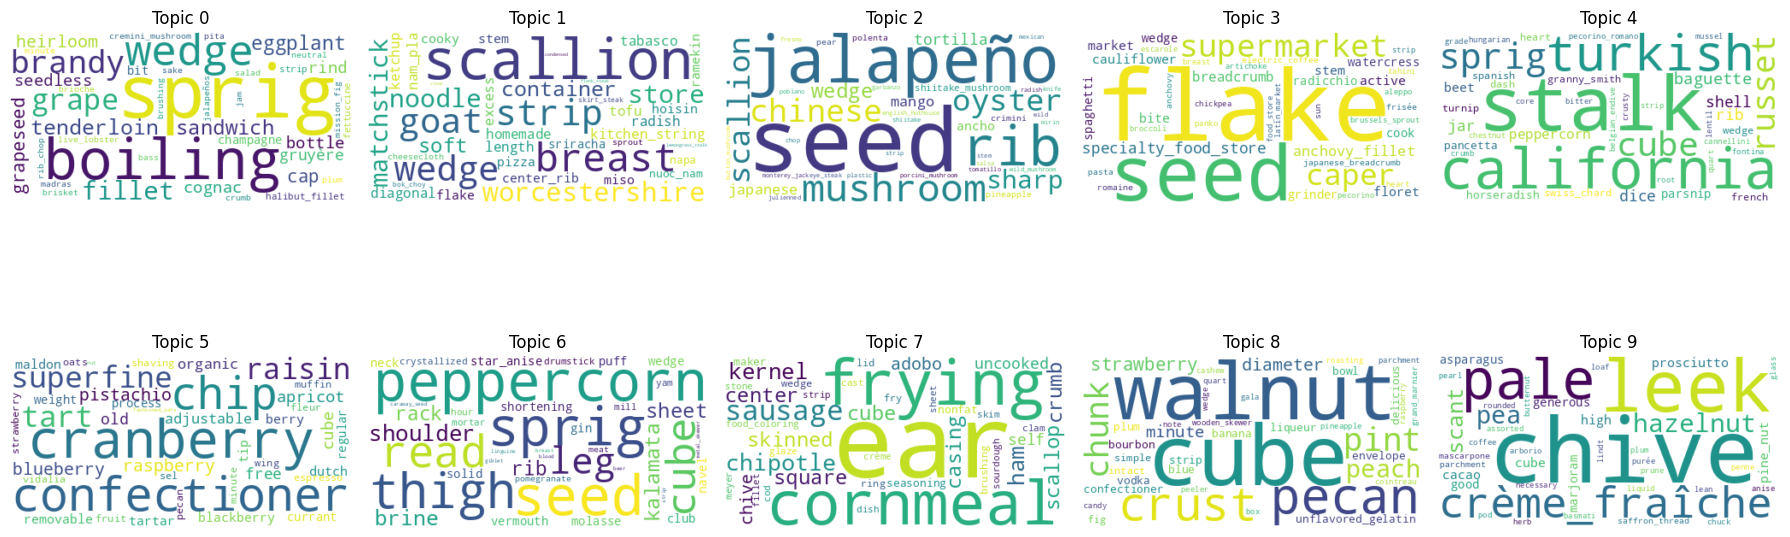

In [70]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < NUM_TOPICS:
        topic_terms = dict(lda_model.show_topic(i, 40))
        wc = WordCloud(background_color="white").generate_from_frequencies(topic_terms)
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Topic {i}")
        ax.axis("off")
    else:
        ax.remove()
plt.tight_layout()
plt.show()


In [71]:
def get_top_topic(bow):
    if not bow:
        return -1
    topic_probs = lda_model.get_document_topics(bow)
    if not topic_probs:
        return -1
    topic_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    return topic_probs[0][0]

df["Top_Topic"] = [get_top_topic(bow) for bow in corpus]
df.head()

,Unnamed: 0,Title,Ingredients,Instructions,Image_Name,Cleaned_Ingredients,_raw_list,Parsed_Ingredients_v2,Ingredient_Tokens,Ingredient_Final,Top_Topic
0,0,Miso-Butter Roast Chicken With Acorn Squash Panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ loaf good-quality sturdy white bread, torn into 1"" pieces (about 2½ cups)', '2 medium apples (such as Gala or Pink Lady; about 14 oz. total), cored, cut into 1"" pieces', '2 Tbsp. extra-virgin olive oil', '½ small red onion, thinly sliced', '3 Tbsp. apple cider vinegar', '1 Tbsp. white miso', '¼ cup all-purpose flour', '2 Tbsp. unsalted butter, room temperature', '¼ cup dry white wine', '2 cups unsalted chicken broth', '2 tsp. white miso', 'Kosher salt, freshly ground pepper']","Pat chicken dry with paper towels, season all over with 2 tsp. salt, and tie legs together with kitchen twine. Let sit at room temperature 1 hour.\nMeanwhile, halve squash and scoop out seeds. Run a vegetable peeler along ridges of squash halves to remove skin. Cut each half into ½""-thick wedges; arrange on a rimmed baking sheet.\nCombine sage, rosemary, and 6 Tbsp. melted butter in a large bowl; pour half of mixture over squash on baking sheet. Sprinkle squash with allspice, red pepper flakes, and ½ tsp. salt and season with black pepper; toss to coat.\nAdd bread, apples, oil, and ¼ tsp. salt to remaining herb butter in bowl; season with black pepper and toss to combine. Set aside.\nPlace onion and vinegar in a small bowl; season with salt and toss to coat. Let sit, tossing occasionally, until ready to serve.\nPlace a rack in middle and lower third of oven; preheat to 425°F. Mix miso and 3 Tbsp. room-temperature butter in a small bowl until smooth. Pat chicken dry with paper towels, then rub or brush all over with miso butter. Place chicken in a large cast-iron skillet and roast on middle rack until an instant-read thermometer inserted into the thickest part of breast registers 155°F, 50–60 minutes. (Temperature will climb to 165°F while chicken rests.) Let chicken rest in skillet at least 5 minutes, then transfer to a plate; reserve skillet.\nMeanwhile, roast squash on lower rack until mostly tender, about 25 minutes. Remove from oven and scatter reserved bread mixture over, spreading into as even a layer as you can manage. Return to oven and roast until bread is golden brown and crisp and apples are tender, about 15 minutes. Remove from oven, drain pickled onions, and toss to combine. Transfer to a serving dish.\nUsing your fingers, mash flour and butter in a small bowl to combine.\nSet reserved skillet with chicken drippings over medium heat. You should have about ¼ cup, but a little over or under is all good. (If you have significantly more, drain off and set excess aside.) Add wine and cook, stirring often and scraping up any browned bits with a wooden spoon, until bits are loosened and wine is reduced by about half (you should be able to smell the wine), about 2 minutes. Add butter mixture; cook, stirring often, until a smooth paste forms, about 2 minutes. Add broth and any reserved drippings and cook, stirring constantly, until combined and thickened, 6–8 minutes. Remove from heat and stir in miso. Taste and season with salt and black pepper.\nServe chicken with gravy and squash panzanella alongside.",miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher salt, divided, plus more', '2 small acorn squash (about 3 lb. total)', '2 Tbsp. finely chopped sage', '1 Tbsp. finely chopped rosemary', '6 Tbsp. unsalted butter, melted, plus 3 Tbsp. room temperature', '¼ tsp. ground allspice', 'Pinch of crushed red pepper flakes', 'Freshly ground black pepper', '⅓ l

In [72]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

In [ ]:
SBERT_MODEL_NAME = "all-MiniLM-L6-v2"

print("Loading SBERT model:", SBERT_MODEL_NAME)
model = SentenceTransformer(SBERT_MODEL_NAME)
print("Model loaded.")

Loading SBERT model: all-MiniLM-L6-v2


c:\Users\chris\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model loaded.


In [ ]:
EMB_CACHE = "recipe_embeddings.npy"
TEXT_CACHE = "ingredient_texts.npy" 

assert "Ingredient_Final" in df.columns, "Ingredient_Final not found — run preprocessing cells first."

ingredient_texts = df["Ingredient_Final"].apply(lambda lst: " ".join(lst) if isinstance(lst, list) else "").astype(str).tolist()

if os.path.exists(EMB_CACHE):
    print("Loading cached embeddings from", EMB_CACHE)
    recipe_embeddings = np.load(EMB_CACHE)
else:
    print("Encoding", len(ingredient_texts), "recipes — this may take a minute.")
    recipe_embeddings = model.encode(ingredient_texts, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=True)
    np.save(EMB_CACHE, recipe_embeddings)
    print("Saved embeddings to", EMB_CACHE)

print("Embeddings shape:", recipe_embeddings.shape)

Loading cached embeddings from recipe_embeddings.npy
Embeddings shape: (13493, 384)


In [75]:
def normalize_ingredients(ingredients_list):
    norm = []
    for ing in ingredients_list:
        ing = ing.lower()
        ing = re.sub(r"\([^)]*\)", "", ing)
        ing = re.sub(r"[^a-zA-Z ]+", "", ing)
        words = [w.strip() for w in ing.split() if len(w) > 2]
        norm.extend(words)
    return list(set(norm))

df["Ingredient_Final"] = df["Ingredients"].apply(eval).apply(normalize_ingredients)


In [76]:
model = SentenceTransformer("all-MiniLM-L6-v2")

c:\Users\chris\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [77]:
recipes_text = df["Ingredient_Final"].apply(lambda x: " ".join(x)).tolist()
recipe_embeddings = model.encode(recipes_text, batch_size=32, convert_to_tensor=True, show_progress_bar=True)

np.save("recipe_embeddings.npy", recipe_embeddings.cpu().numpy())


Batches: 100%|██████████| 422/422 [01:29<00:00,  4.72it/s]


In [78]:
import torch

In [ ]:
recipe_embeddings = torch.tensor(np.load("recipe_embeddings.npy"))
recipe_embeddings.shape

torch.Size([13493, 384])

In [ ]:
def recommend_recipes(user_ingredients, df, top_k=10, alpha=0.7, beta=0.3):
    if "recipe_embeddings" not in globals():
        raise RuntimeError("recipe_embeddings not found. Run the embedding build cell first.")
    if model is None:
        raise RuntimeError("SBERT `model` not found. Load the model before calling this.")

    re_emb = recipe_embeddings
    if isinstance(re_emb, np.ndarray):
        re_emb = torch.tensor(re_emb)
    if isinstance(re_emb, list):
        re_emb = torch.tensor(np.array(re_emb))
    re_emb = re_emb.float()

    if isinstance(user_ingredients, str):
        user_list = [user_ingredients]
    else:
        user_list = list(user_ingredients)

    def simple_normalize_list(lst):
        out = []
        for s in lst:
            if not isinstance(s, str):
                continue
            s2 = s.lower()
            s2 = re.sub(r"\([^)]*\)", " ", s2)
            s2 = re.sub(r"[^a-z\s]", " ", s2)
            toks = [w.strip() for w in s2.split() if len(w.strip()) > 2]
            out.extend(toks)

        return list(dict.fromkeys(out))

    query_tokens = simple_normalize_list(user_list)
    if len(query_tokens) == 0:
        return pd.DataFrame({"Message": ["No valid ingredients detected after normalization."]})

    query_text = " ".join(query_tokens)
    q_emb = model.encode(query_text, convert_to_tensor=True, normalize_embeddings=True)

    with torch.no_grad():
        if not torch.allclose(re_emb.norm(dim=1), torch.ones(re_emb.size(0)), atol=1e-3):
            re_emb = torch.nn.functional.normalize(re_emb, dim=1)


    sims = util.cos_sim(q_emb, re_emb)[0] 
    sims = sims.cpu().numpy()

    rows = []
    for i, toks in enumerate(df["Ingredient_Final"]):
        recipe_tokens = []
        if isinstance(toks, list):
            recipe_tokens = [str(x).lower() for x in toks]
        elif isinstance(toks, str):
            recipe_tokens = simple_normalize_list([toks])
        else:
            recipe_tokens = []

        overlap = len(set(query_tokens) & set(recipe_tokens)) / max(1, len(query_tokens))
        similarity = float(sims[i])
        final_score = alpha * similarity + beta * overlap

        rows.append({
            "idx": i,
            "Title": df.iloc[i]["Title"],
            "Ingredients": df.iloc[i]["Ingredients"],
            "Ingredient_Final": recipe_tokens,
            "Similarity": round(similarity, 6),
            "Overlap": round(overlap, 3),
            "FinalScore": round(final_score, 6)
        })

    results_df = pd.DataFrame(rows)
    results_df = results_df.sort_values("FinalScore", ascending=False).reset_index(drop=True)

    return results_df.head(top_k)[["Title","Similarity","Overlap","FinalScore","Ingredients","Ingredient_Final"]]



In [81]:
recommend_recipes(["chicken", "rice"], df)

,Title,Similarity,Overlap,FinalScore,Ingredients,Ingredient_Final
0,Crunchy Gluten-Free Chicken Tenders,0.655333,1.0,0.758733,"['2 cups gluten-free Rice Chex cereal', ""1 cup Amy's Gluten-Free Mix or store-bought gluten-free flour"", '1 teaspoon salt', '1 teaspoon black pepper', '2 large eggs', '1 pound chicken tenderloins', '3 cups vegetable oil']","[salt, oil, cup, teaspoon, cups, rice, chex, storebought, amys, chicken, vegetable, large, cereal, tenderloins, pepper, glutenfree, mix, flour, eggs, black, pound]"
1,Rice Pilaf with Pine Nuts,0.643551,1.0,0.750485,"['1 tablespoon olive oil', '1 small onion, finely chopped', '1 cup long-grain white rice', '1 1/2 cups low-salt chicken broth', '1/2 cup pine nuts, toasted if desired']","[oil, tablespoon, small, cup, cups, chopped, nuts, rice, broth, onion, chicken, desired, finely, olive, lowsalt, longgrain, pine, toasted, white]"
2,Chilled and Dilled Avgolemono Soup,0.640850,1.0,0.748595,"['4 cups chicken stock, or 3 cups reduced-sodium chicken broth plus 1 cup water', '1/4 cup medium-or long-grain white rice', '2 large eggs', '3 tablespoons fresh lemon juice', '1 scallion green, thinly sliced', '2 tablespoons chopped dill']","[thinly, fresh, cup, cups, chopped, juice, sliced, rice, dill, scallion, broth, stock, mediumor, chicken, large, reducedsodium, lemon, longgrain, water, tablespoons, green, white, eggs, plus]"
3,Chicken Teriyaki,0.635734,1.0,0.745014,"['5 skin-on, boneless chicken thighs (about 1 1/2 lb. total)', '1 1/2 tsp. kosher salt, divided', '1/3 cup low-sodium soy sauce', '1/3 cup mirin (sweet Japanese rice wine)', '1/3 cup sake', '5 radishes, trimmed, thinly sliced', '5 scallions, thinly sliced on a diagonal', '2 tsp. unseasoned rice vinegar', 'Cooked white rice (for serving)']","[salt, thinly, cooked, thighs, scallions, cup, sliced, vinegar, rice, divided, sake, soy, radishes, kosher, chicken, trimmed, lowsodium, sauce, skinon, unseasoned, diagonal, tsp, boneless, white, mirin]"
4,Soy-Glazed Chicken with Broccoli,0.629255,1.0,0.740478,"['3 Tbsp. honey', '3 Tbsp. soy sauce or tamari', '3 Tbsp. unseasoned rice vinegar', '1 tsp. finely grated ginger (from one 2"" piece)', '1 Tbsp. vegetable oil', '4 skinless, boneless chicken thighs', '1 1/2 tsp. kosher salt, divided, plus more', '1 large head of broccoli, cut into florets', 'Steamed rice (for serving)', 'Sliced scallions, toasted sesame seeds, and hot sesame oil (for serving; optional)']","[salt, head, seeds, oil, thighs, scallions, vinegar, sliced, rice, divided, hot, steamed, soy, kosher, cut, more, honey, chicken, tamari, skinless, vegetable, large, finely, and, florets, sesame, ginger, sauce, unseasoned, into, tbsp, grated, tsp, boneless, toasted, plus, broccoli]"
5,Chicken and Cilantro Bites,0.618869,1.0,0.733209,"['1/4 cup soy sauce', '1/4 cup rice vinegar (not seasoned)', '1 lb ground chicken (not breast meat)', '1 large egg', '1/2 cup finely chopped fresh cilantro', '2 scallions, finely chopped', '2 teaspoons Asian sesame oil', '1 teaspoon salt', '3/4 cup cornstarch', '1/2 cup vegetable oil']","[salt, fresh, teaspoons, oil, scallions, cup, teaspoon, chopped, vinegar, cilantro, rice, soy, egg, cornstarch, chicken, vegetable, large, finely, sesame, sauce, asian, ground]"
6,Chicken Stir-Fry with Peanut Sauce Over Rice,0.608251,1.0,0.725776,"['Vegetable-oil cooking spray', '6 oz boneless, skinless chicken breast, sliced', '1 tsp sesame oil', '2 cloves garlic, minced', '1 tsp minced fresh ginger', '3 1/2 cups of your favorite vegetables, chopped', '1 1/2 tbsp peanut butter', '1 tsp low-sodium soy sauce', '1 tbsp rice vinegar', 'Hot chile sauce (to taste)']","[chile, butter, fresh, minced, oil, cups, chopped, sliced, vinegar, vegetableoil, rice, vegetables, hot, soy, cooking, peanut, your, chicken, cloves, skinless, lowsodium, favorite, sesame, breast, ginger, sauce, spray, tbsp, tsp, boneless, garlic]"
7,Jasmine Rice with Peanuts and Scallions,0.603694,1.0,0.722586,"['2 cups jasmine rice (13 oz)', '2 cups water', '1 

In [82]:
assert "Image_Name" in df.columns, "Image_Name column missing!"
df["Image_Path"] = "Images/" + df["Image_Name"]

In [87]:
print(df.columns)

Index(['Unnamed: 0', 'Title', 'Ingredients', 'Instructions', 'Image_Name',
       'Cleaned_Ingredients', '_raw_list', 'Parsed_Ingredients_v2',
       'Ingredient_Tokens', 'Ingredient_Final', 'Top_Topic', 'Image_Path'],
      dtype='object')


In [85]:
df.to_parquet("recipes_final_with_images.parquet", index=False, engine="fastparquet")
print("Saved recipes_final_with_images.parquet")

Saved recipes_final_with_images.parquet


In [86]:
df.to_parquet("recipes_final_with_images.parquet", index=False)

from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(
    df["Ingredient_Final"].apply(lambda x: " ".join(x)).tolist(),
    convert_to_tensor=False
)

np.save("recipe_embeddings.npy", embeddings)

c:\Users\chris\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
